In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Input,Flatten,Reshape,AveragePooling2D,Dropout,LayerNormalization, ReLU,concatenate,Cropping2D, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Input,Dropout, ReLU,BatchNormalization,Concatenate,LeakyReLU,Identity
import tensorflow as tf

import keras
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


2024-08-02 13:04:52.858211: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
from PIL import Image, ImageDraw, ImageFont
font_path = '../dados/targa/Targa.ttf'

In [4]:
!wget  -nc https://www.dropbox.com/scl/fi/uaiyxp0t2l8hfcszfadtj/dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius&dl=1
!unzip -n -q dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
unzip:  cannot find or open dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius, dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.zip or dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.ZIP.

No zipfiles found.


In [5]:
image_path = '../dados/CAPTCHA-10k/treinamento'
def generate_df(image_path):
  label_path = '../dados/CAPTCHA-10k/labels10k'

  jpg_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]
  jpg_files.sort()
  data = []

  for jpg_file in jpg_files:
      txt_file = os.path.splitext(jpg_file)[0] + '.txt'
      txt_file_path = os.path.join(label_path, txt_file)

      if os.path.exists(txt_file_path):
          with open(txt_file_path, 'r') as file:
              txt_content = file.read().strip()

          data.append({'jpg_file': jpg_file, 'txt_content': txt_content})
  return pd.DataFrame(data)

df = generate_df(image_path)
df.head()

,jpg_file,txt_content
0,000001.jpg,RNINIC
1,000002.jpg,TVCFS8
2,000003.jpg,N1O1EH
3,000004.jpg,OQZSL4
4,000005.jpg,GST2YA


In [6]:
vocab = np.unique(list(df['txt_content'].sum()) + ["]"])
np.array(vocab)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'A', 'B',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
       'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', ']'],
      dtype='<U1')

In [7]:
def generate_clean_captcha(text):
    # Fixed parameters
    size = (180, 50)  # Change size to (height, width)
    font_size = 24
    num_parts = 7

    # Create a blank white image
    image = Image.new('L', size, 255)  # 'L' mode for grayscale

    # Load the custom font
    font = ImageFont.truetype(font_path, font_size)

    # Create a drawing context
    draw = ImageDraw.Draw(image)

    # Calculate positions for each part
    part_width = size[0] / num_parts
    horizontal_positions = [int(part_width * i + part_width / 2) for i in range(num_parts)]
    horizontal_positions = horizontal_positions[:len(text)]  # Adjust to the length of the text

    # Calculate y position to center the text vertically
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_height = text_bbox[3] - text_bbox[1]
    text_y = (size[1] - text_height) // 2

    # Draw each letter at the calculated position
    for char, x in zip(text, horizontal_positions):
        char_bbox = draw.textbbox((0, 0), char, font=font)
        char_width = char_bbox[2] - char_bbox[0]
        char_x = x - char_width // 2  # Center the character horizontally within its part
        draw.text((char_x, text_y), char, font=font, fill=0)

    # Convert to numpy array if needed for further processing with OpenCV
    captcha_image = np.array(image)

    return captcha_image

In [8]:
def generate_X_Y(image_path):
  df = generate_df(image_path)
  df['txt_content'] = df['txt_content'].apply(lambda x: x + "]" if len(x) == 6 else x)

  num_classes = len(vocab)
  char_to_index = {char: idx for idx, char in enumerate(vocab)}
  X = []
  Y = []

  for text in df['txt_content']:
    x = generate_clean_captcha(text)
    interval = [0, 25, 50, 75, 100, 125, 150, 175]  # Adjusted intervals for 7 parts
    for i in range(len(interval)-1):
        fake_img = x[:,interval[i]:interval[i+1]]
        y = np.zeros((1,num_classes))
        y[0,char_to_index[text[i]]] = 1
        X.append(fake_img)
        Y.append(y)

  X = np.array(X)
  Y = np.array(Y)

  X = (X.astype('float32'))  / 255.0

  X = X.reshape(-1,50,25,1)
  Y = Y.reshape(-1,num_classes)
  return X,Y

X,Y = generate_X_Y('../dados/CAPTCHA-10k/treinamento')

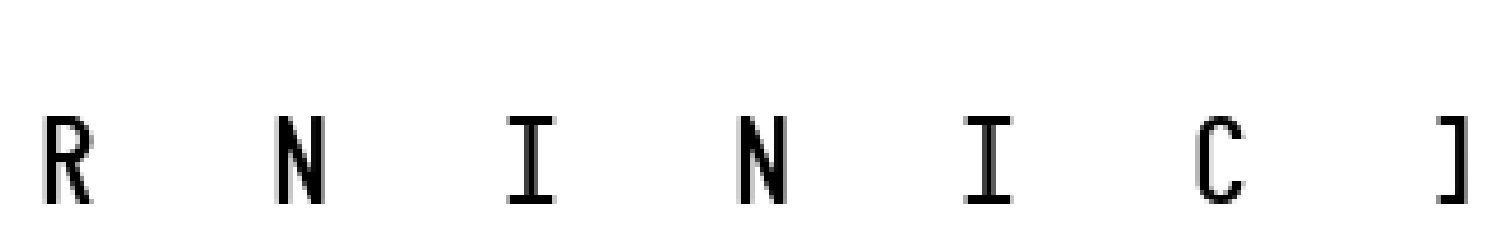

In [9]:
fig, axes = plt.subplots(1, 7, figsize=(20, 3))
for i in range(7):
    axes[i].imshow(X[i].reshape(50, 25), cmap='gray')
    axes[i].axis('off')
plt.show()

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

datagen.fit(X)
batch_size = 8
augmented_data_generator = datagen.flow(X, Y, batch_size=batch_size)

In [11]:
#Camada Convolution-BatchNorm-ReLu
def CK(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', use_batch_norm=True, downsample=True):
    '''
        filters: quantidade de filtros
        kernel_size 3x3 | strides 1x1 | padding same | sao constantes durante o codigo
        use_batch_norm ->   indica quando devemos usar BatchNormalization, em caso de negativo, a camada se torna a Identidade
        downsample ->       indica se a dimensao deve aumentar ou diminuir 
    '''

    # Esse chavemento usando  if ternario serve para selecionar as camadas com base nos atributos
    conv = Conv2D               if downsample       else Conv2DTranspose
    norm = BatchNormalization   if use_batch_norm   else Identity
    actf = LeakyReLU(0.2)       if downsample       else ReLU()
    # alpha de 0.2 na LeakyReLU foi definido no paper original

    # Com o chaveamento pronto, a camada pode ser montada sequencialmente
    def layer(x):
        x = conv(filters, kernel_size, strides=strides, padding=padding)(x)
        x = norm()(x)
        x = actf(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        return x
    return layer

In [12]:
def discriminator(output_nc, ngf, num_downsample=3):

    # O discriminador por sua vez, recebe a entrada e a saida do modelo, tentando assim decidir se aquilo 'e real ou nao
    tar = Input(shape=[50, 25, output_nc], name='target_image')

    # Initial convolutional layers # SEM BATCH NORM !
    x = CK(ngf,use_batch_norm=False)(tar)

    # Contracting path
    for i in range(num_downsample):
        x = CK(ngf*(2**(i+1)))(x)
    
    # Por fim, a patchGan gera uma classificao binaria por patch, o tamanho do patch eh definido pelo num_downsample. Quanto maior, menor a area de recepcao
    # Por exemplo num_downsample = 4 faz com que o discriminador classifique blocos de 16x16
    x = Conv2D(ngf, (1, 1),activation='ReLU')(x)
    x = Flatten()(x)
    # x = Dense(64,activation="ReLU")(x)
    x = Dense(38,activation="softmax")(x)
    return Model(inputs=tar, outputs=x)

classifier = discriminator(1,16,4)
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 target_image (InputLayer)   [(None, 50, 25, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 50, 25, 16)        160       
                                                                 
 identity (Identity)         (None, 50, 25, 16)        0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 50, 25, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 13, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 13, 32)        4640      
                                                             

2024-08-02 13:04:59.079883: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13856 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [13]:
class StopTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') == 1.0:
            print("\nReached 100% accuracy, stopping training!")
            self.model.stop_training = True
        
        if logs.get('val_accuracy') == 1.0:
            print("\nReached 100% accuracy on val, stopping training!")
            self.model.stop_training = True

checkpoint = ModelCheckpoint(
    'classifier_pre_trained_best.tf',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [14]:
stop_training_callback = StopTrainingCallback()
classifier.fit(augmented_data_generator,steps_per_epoch=len(X) // batch_size, epochs=500, 
               callbacks=[stop_training_callback,checkpoint],
               validation_data=(X, Y))

Epoch 1/500


2024-08-02 13:05:01.045343: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-08-02 13:05:01.518572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-08-02 13:05:01.559882: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbeb851f9d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-02 13:05:01.560041: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-08-02 13:05:01.566296: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-02 13:05:01.700411: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

6995/7000 [============================>.] - ETA: 0s - loss: 0.1523 - accuracy: 0.9598
Reached 100% accuracy on val, stopping training!

Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to classifier_pre_trained_best.tf
INFO:tensorflow:Assets written to: classifier_pre_trained_best.tf/assets


INFO:tensorflow:Assets written to: classifier_pre_trained_best.tf/assets


7000/7000 [==============================] - 49s 6ms/step - loss: 0.1522 - accuracy: 0.9598 - val_loss: 6.9848e-06 - val_accuracy: 1.0000


In [15]:
classifier.save("classifier_pre_trained.tf")

INFO:tensorflow:Assets written to: classifier_pre_trained.tf/assets


INFO:tensorflow:Assets written to: classifier_pre_trained.tf/assets


In [16]:
classifier.evaluate(X,Y)

1750/1750 [==============================] - 5s 3ms/step - loss: 6.9848e-06 - accuracy: 1.0000


[6.984756964811822e-06, 1.0]